In [ ]:
#Setup!
!pip3 install torch torchvision torchaudio
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
!pip install kaggle
%matplotlib inline
from fastai.vision.all import *
from pathlib import Path

In [2]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.3 MB/s 


In [3]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import random

import tarfile
import io
import os
import pandas as pd

from torch.utils.data import Dataset
import torch

# Dataset

In [4]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Unzip all data in a local env
!unzip gdrive/My\ Drive/Colab_Dataset/Classification.zip

In [6]:
# Dataset
path = Path('/content/Classification/')
path.ls()

(#24) [Path('/content/Classification/classification.csv'),Path('/content/Classification/7463'),Path('/content/Classification/7117'),Path('/content/Classification/test.csv'),Path('/content/Classification/7434'),Path('/content/Classification/7426'),Path('/content/Classification/train.csv'),Path('/content/Classification/9866'),Path('/content/Classification/7585'),Path('/content/Classification/9852')...]

## CSV File

Here I gether intel about the CSV file. Here I get an idea about how the object looks like (ID, habitats, labels, classes, frames, Name).

In [51]:
df = pd.read_csv(path/"classification.csv")
df.head()

,ID,habitats,labels,classes,frames
0,7117/empty/7117_no_fish_2_f000000,7117,0,empty,7117_no_fish_2_f000000
1,7117/empty/7117_no_fish_2_f000001,7117,0,empty,7117_no_fish_2_f000001
2,7117/empty/7117_no_fish_2_f000002,7117,0,empty,7117_no_fish_2_f000002
3,7117/empty/7117_no_fish_2_f000003,7117,0,empty,7117_no_fish_2_f000003
4,7117/empty/7117_no_fish_2_f000004,7117,0,empty,7117_no_fish_2_f000004


In [52]:
df.iloc[:,0]

0          7117/empty/7117_no_fish_2_f000000
1          7117/empty/7117_no_fish_2_f000001
2          7117/empty/7117_no_fish_2_f000002
3          7117/empty/7117_no_fish_2_f000003
4          7117/empty/7117_no_fish_2_f000004
                        ...                 
39761    9908/valid/9908_Epinephelus_f000183
39762    9908/valid/9908_Epinephelus_f000184
39763    9908/valid/9908_Epinephelus_f000185
39764    9908/valid/9908_Epinephelus_f000186
39765    9908/valid/9908_Epinephelus_f000187
Name: ID, Length: 39766, dtype: object

In [62]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[39765]

ID          9908/valid/9908_Epinephelus_f000187
habitats                                   9908
labels                                        1
classes                                   valid
frames                 9908_Epinephelus_f000187
Name: 39765, dtype: object

In [54]:
df['ID']

0          7117/empty/7117_no_fish_2_f000000
1          7117/empty/7117_no_fish_2_f000001
2          7117/empty/7117_no_fish_2_f000002
3          7117/empty/7117_no_fish_2_f000003
4          7117/empty/7117_no_fish_2_f000004
                        ...                 
39761    9908/valid/9908_Epinephelus_f000183
39762    9908/valid/9908_Epinephelus_f000184
39763    9908/valid/9908_Epinephelus_f000185
39764    9908/valid/9908_Epinephelus_f000186
39765    9908/valid/9908_Epinephelus_f000187
Name: ID, Length: 39766, dtype: object

In [55]:
df['classes']

0        empty
1        empty
2        empty
3        empty
4        empty
         ...  
39761    valid
39762    valid
39763    valid
39764    valid
39765    valid
Name: classes, Length: 39766, dtype: object

## Train

In the beginning I tried to follow the FastAI course example at using DataBlock with CSV file. I got the error (FileNotFoundError: [Errno 2] No such file or directory: '/content/Classification/9908/valid/9908_Epinephelus_f000187'). This did not make sense for me since you can clearly see in (df.iloc[:,0]) that it does in fact exist. I decided to use Datablock with Path where I used regular expression to find and create the categories.

If the plan went my way I would have used get_x() to retrieve the image file, get_y() to retrive the classes (classes are either valid or empty), and splitter() to split the dataset.

In [56]:
def get_x(r): return path/r['ID']
def get_y(r): return r['classes'].split(' ')
def splitter(df):
    train = df.index[~df['labels']].tolist()
    valid = df.index[df['labels']].tolist()
    return train,valid
dblock = DataBlock(splitter=splitter, get_x = get_x, get_y = get_y, item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dsets = dblock.datasets(df)
dsets.train[23546]

(Path('/content/Classification/9908/valid/9908_Epinephelus_f000186'),
 ['valid'])

In [57]:
def get_x(r): return path/r['ID']
def get_y(r): return r['classes'].split(' ')
def splitter(df):
    train = df.index[~df['labels']].tolist()
    valid = df.index[df['labels']].tolist()
    return train,valid

In [ ]:
# //Failed attempt
#dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
#                   splitter=splitter,
#                   get_x=get_x, 
#                   get_y=get_y,
#                   item_tfms=Resize(460),
#                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
#dls = dblock.dataloaders(df)

In [63]:
fish = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'\d+_([a-zA-Z\d]+)_.+.jpg$'), 'name'), # Using regular expression
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = fish.dataloaders(path)

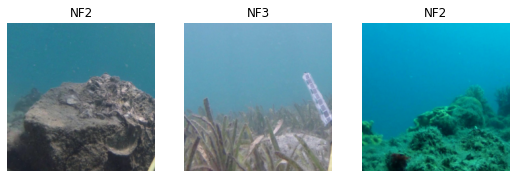

In [64]:
dls.show_batch(nrows=1, ncols=3)

Let's train!

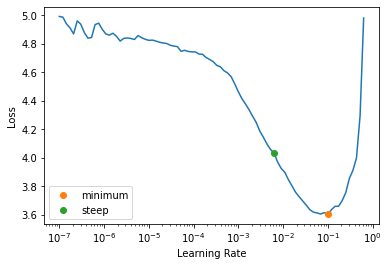

In [89]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [90]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-03


In [91]:
learn.fine_tune(2, base_lr=6.31e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.100428,0.694645,0.230102,23:29


epoch,train_loss,valid_loss,error_rate,time
0,0.543015,0.399535,0.150006,23:38
1,0.253555,0.135404,0.043883,23:57


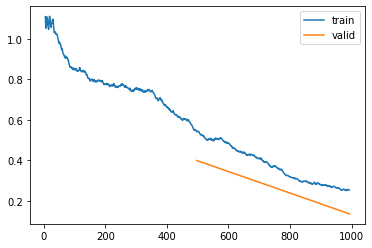

In [92]:
learn.recorder.plot_loss()

As seen in the fine_tune() function, I got a really good result after only 2 epochs. Unfortuantly I got a bad plot_loss(). This is called a Underfit Model, which is a model that fails to sufficiently learn the problem and performs poorly on a training dataset and does not perform well on a holdout sample. 

As you can see in the confusion matrix there are categories which doesn not make sens. F1... F7 means that there are fish in the image. NF1...NF6 means that there are no fish in the image, and no is short for no_fish. The dataset contains a large amount of no fish images and would be better to have a dataset which focused on the fishes. The reason this happened was that when I tried my first attempt with the CSV file I had to include the whole dataset. 

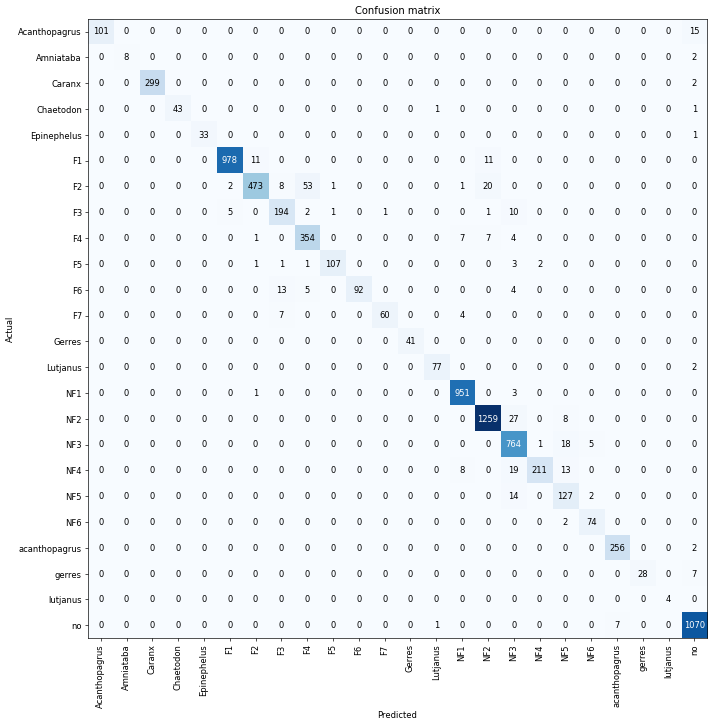

In [93]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [94]:
interp.most_confused(min_val=5)

[('F2', 'F4', 53),
 ('NF2', 'NF3', 27),
 ('F2', 'NF2', 20),
 ('NF4', 'NF3', 19),
 ('NF3', 'NF5', 18),
 ('Acanthopagrus', 'no', 15),
 ('NF5', 'NF3', 14),
 ('F6', 'F3', 13),
 ('NF4', 'NF5', 13),
 ('F1', 'F2', 11),
 ('F1', 'NF2', 11),
 ('F3', 'NF3', 10),
 ('F2', 'F3', 8),
 ('NF2', 'NF5', 8),
 ('NF4', 'NF1', 8),
 ('F4', 'NF1', 7),
 ('F4', 'NF2', 7),
 ('F7', 'F3', 7),
 ('gerres', 'no', 7),
 ('no', 'acanthopagrus', 7),
 ('F3', 'F1', 5),
 ('F6', 'F4', 5),
 ('NF3', 'NF6', 5)]

In [95]:
learn.export('fish')

## Predictions

In [96]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [97]:
def on_click(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(512,512))
  pred, pred_idx, probs = learn.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [98]:
btn_upload.observe(on_click, names=['data'])

In [99]:
display(VBox([widgets.Label('Select a image'), btn_upload, out_pl, lbl_pred]))

## Save?

In [100]:
learn.export()